In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
# 读入 DAU（每天至少来访1次的用户）数据
DAU_table = pd.read_csv('./data/section3-dau.csv')
DAU_table.head()

,log_date,app_name,user_id
0,2013-06-01,game-01,116
1,2013-06-01,game-01,13491
2,2013-06-01,game-01,7006
3,2013-06-01,game-01,117
4,2013-06-01,game-01,13492


In [3]:
# 读入 DPU（每天至少消费1日元的用户）数据
DPU_table = pd.read_csv('./data/section3-dpu.csv')
DPU_table.head()

,log_date,app_name,user_id,payment
0,2013-06-01,game-01,351,1333
1,2013-06-01,game-01,12796,81
2,2013-06-01,game-01,364,571
3,2013-06-01,game-01,13212,648
4,2013-06-01,game-01,13212,1142


In [4]:
# 读入 Install（记录每个用户首次玩游戏的时间）数据
Install_table = pd.read_csv('./data/section3-install.csv')
Install_table.head()

,install_date,app_name,user_id
0,2013-04-15,game-01,1
1,2013-04-15,game-01,2
2,2013-04-15,game-01,3
3,2013-04-15,game-01,4
4,2013-04-15,game-01,5


In [5]:
# 合并 DAU 和 Install 以及 DPU
merge_1 = pd.merge(DAU_table,Install_table,how='left',left_on='user_id',right_on='user_id',sort=True)
merge_1 = merge_1.rename(columns = {'app_name_x': 'app_name'})
merge_1 =merge_1[['user_id','app_name','log_date','install_date']]
# merge_1.head()

merge_2 = pd.merge(merge_1,DPU_table,how='left',left_on=['user_id','log_date'],right_on=['user_id','log_date'],sort=True)
merge_2 = merge_2.rename(columns = {'app_name_x': 'app_name'})
merge_2 = merge_2[['user_id','app_name','log_date','install_date','payment']]
merge_2.head()

,user_id,app_name,log_date,install_date,payment
0,1,game-01,2013-06-01,2013-04-15,NaN
1,1,game-01,2013-06-02,2013-04-15,NaN
2,1,game-01,2013-06-03,2013-04-15,NaN
3,1,game-01,2013-06-04,2013-04-15,NaN
4,1,game-01,2013-06-05,2013-04-15,NaN


In [6]:
# 将未消费用户的消费额设置为0
merge_2.fillna(0, inplace=True)
merge_2.head()

,user_id,app_name,log_date,install_date,payment
0,1,game-01,2013-06-01,2013-04-15,0.0
1,1,game-01,2013-06-02,2013-04-15,0.0
2,1,game-01,2013-06-03,2013-04-15,0.0
3,1,game-01,2013-06-04,2013-04-15,0.0
4,1,game-01,2013-06-05,2013-04-15,0.0


In [7]:
# 按月统计
merge_2['访问月份'] = merge_2['log_date'].map(lambda x: x.split('-')[0] + '年' + x.split('-')[1].split('-')[0] + '月')
merge_2['首次使用月份'] = merge_2['install_date'].map(lambda x: x.split('-')[0] + '年' + x.split('-')[1].split('-')[0] + '月')
# merge_2.head()

month_group = merge_2.groupby(['user_id','访问月份','首次使用月份'])['payment'].sum().reset_index()
month_group.head()

,user_id,访问月份,首次使用月份,payment
0,1,2013年06月,2013年04月,0.0
1,1,2013年07月,2013年04月,0.0
2,2,2013年06月,2013年04月,0.0
3,3,2013年06月,2013年04月,14994.0
4,3,2013年07月,2013年04月,0.0


In [8]:
# 按月统计的数据中区分新用户和已有用户
month_group['用户分类'] = np.where(month_group['访问月份'] == month_group['首次使用月份'],'新用户','已有用户')
month_group.head()

,user_id,访问月份,首次使用月份,payment,用户分类
0,1,2013年06月,2013年04月,0.0,已有用户
1,1,2013年07月,2013年04月,0.0,已有用户
2,2,2013年06月,2013年04月,0.0,已有用户
3,3,2013年06月,2013年04月,14994.0,已有用户
4,3,2013年07月,2013年04月,0.0,已有用户


In [9]:
# 统计不同月份的新用户 / 已有用户的消费额
pivot = pd.pivot_table(month_group,index=['访问月份','用户分类'],values=['payment'],aggfunc=np.sum)
pivot.head()

payment
访问月份     用户分类          
2013年06月 已有用户  177886.0
         新用户    49837.0
2013年07月 已有用户  177886.0
         新用户    29199.0

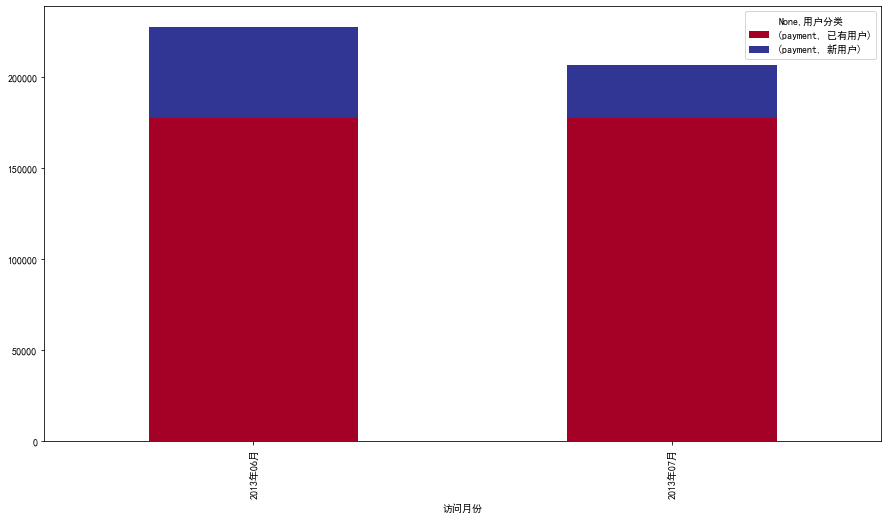

In [10]:
# 不同月份的游戏销售额比较
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False

df = pd.pivot_table(month_group,index=['访问月份'],values=['payment'],columns=['用户分类'],aggfunc=np.sum)
df.plot(kind='bar',colormap='RdYlBu',stacked=True,figsize=(15,8)) 

D:\anaconda_3.7\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


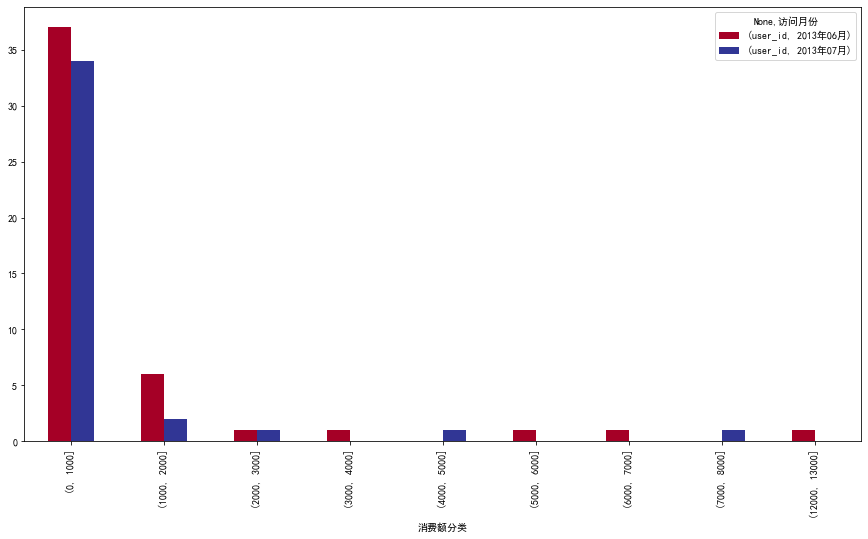

In [11]:
# 不同月份中游戏新用户的消费额比较
df2 = month_group[month_group['用户分类'] == '新用户']
# df2.describe()

df2['消费额分类'] = pd.cut(df2['payment'],[0,1000,2000,3000,4000,5000,6000,7000,8000,9000,10000,11000,12000,13000])
pivot2 = pd.pivot_table(df2,index=['消费额分类'],values=['user_id'],columns=['访问月份'],aggfunc='count')
pivot2.plot(kind='bar',colormap='RdYlBu',figsize=(15,8)) 